# File for looking at simplistic target and pathway overlap using the Jaccard Similarity #

- Using the syntoxtarg_allpw.csv and syntoxtarg_lowestpw.csv

Steps to take:
1. For all available drug combinations, find the Jaccard similarity for targets
2. For all available drug combinations, find the Jaccard similarity for lowest pathway levels
3. For all available drug combinations, find the Jaccard similarity for all pathway levels

In [1]:
# Import everything needed
from matplotlib.patches import Patch
from scipy import stats
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from toxicity_ranking import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns

In [2]:
drug_syntox_df = pd.read_csv('data_processed/syntox_known.csv')
syntoxtarg_allpw_df = pd.read_csv('data_processed/syntoxtarg_allpw.csv')
syntoxtarg_lowestpw_df = pd.read_csv('data_processed/syntoxtarg_lowestpw.csv')

In [3]:
# Function to get the jaccard similarity between two sets of drug targets or pathways
def targ_pw_js(drug1, drug2, target_or_pathway_df, type='target'):
    if type not in ['target', 'pathway']:
        raise ValueError('type must be either target or pathway')
    if type == 'target':
        drug1_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug1]['target_DrugBank_ID'])
        drug2_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug2]['target_DrugBank_ID'])
    else:
        drug1_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug1]['Reactome_ID'])
        drug2_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug2]['Reactome_ID'])
    
    if len(drug1_set) == 0 or len(drug2_set) == 0:
        return None

    return jaccard_similarity(drug1_set, drug2_set)

# Test this function
print(targ_pw_js('ceritinib', 'levonorgestrel', syntoxtarg_allpw_df, type='target')) # Should be zero
print(targ_pw_js('testosterone', 'levonorgestrel', syntoxtarg_allpw_df, type='target')) # Should be positive
print(targ_pw_js('methotrexate', 'chlorphenesin', syntoxtarg_allpw_df, type='target')) # Should be None
print(targ_pw_js('mycophenolic acid', 'rucaparib', syntoxtarg_lowestpw_df, type='pathway')) # Should be zero
print(targ_pw_js('testosterone', 'levonorgestrel', syntoxtarg_allpw_df, type='pathway')) # Should be positive
print(targ_pw_js('methotrexate', 'chlorphenesin', syntoxtarg_allpw_df, type='pathway')) # Should be None


0.0
0.3333333333333333
None
0.0
0.71875
None


In [4]:
# Create a new column in the drug_syntox_df that contains the jaccard similarity between the target sets of the drug pair
drug_syntox_df['target_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_allpw_df, 'target'), axis=1)
drug_syntox_df['all_pw_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_allpw_df, 'pathway'), axis=1)
drug_syntox_df['lowest_pw_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_lowestpw_df, 'pathway'), axis=1)

In [5]:
# How many pairs have a target jaccard similarity of None
print(len(drug_syntox_df[drug_syntox_df['target_jaccard'].isnull()]))

# How many pairs have a target jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['target_jaccard'] == 0]))

# How many pairs have a pathway jaccard similarity of None?
print(len(drug_syntox_df[drug_syntox_df['all_pw_jaccard'].isnull()]))

# How many pairs have a pathway jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['all_pw_jaccard'] == 0]))

# How many pairs have a pathway jaccard similarity of None?
print(len(drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].isnull()]))

# How many pairs have a pathway jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'] == 0]))

drug_syntox_df

8781
26712
8781
2808
8781
17486


,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category,target_jaccard,all_pw_jaccard,lowest_pw_jaccard
0,mefloquine,tamoxifen,TC-32,19.667559,2.263512,25.542924,2.896978,Moderate,0.0,0.027473,0.000000
1,chloroquine,tamoxifen,TC-32,8.836970,-0.671750,11.944238,-0.517536,Major,0.0,0.134199,0.000000
2,prochlorperazine,tamoxifen,TC-32,12.411371,1.358891,14.291624,0.880952,Moderate,0.0,0.065574,0.015625
3,fingolimod,tamoxifen,TC-32,8.007900,-0.764699,5.141360,-0.060902,Major,0.0,0.136546,0.021053
4,dasatinib,tamoxifen,TC-32,-9.601561,0.314544,-5.351887,0.710809,Moderate,0.0,0.211628,0.065789
...,...,...,...,...,...,...,...,...,...,...,...
37840,sunitinib,nilutamide,CBRC058,10.012172,7.477252,-6.487555,-8.811142,Moderate,0.0,0.034483,0.000000
37841,sunitinib,midostaurin,CBRC058,-15.618223,-46.106561,-80.053050,-73.693958,Moderate,0.5,0.521739,0.621053
37842,vincristine,midostaurin,CBRC058,10.768074,5.982307,8.609542,3.406801,Moderate,0.0,0.086207,0.000000
37843,ceritinib,ponatinib,RD,11.951861,-2.135860,11.637520,-1.042661,Major,0.0,0.012903,0.000000


(array([2.6734e+04, 7.5800e+02, 2.8300e+02, 1.2800e+02, 9.9000e+01,
        4.0000e+00, 2.5400e+02, 0.0000e+00, 2.0000e+00, 2.6100e+02,
        3.6600e+02, 0.0000e+00, 0.0000e+00, 5.7000e+01, 0.0000e+00,
        6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

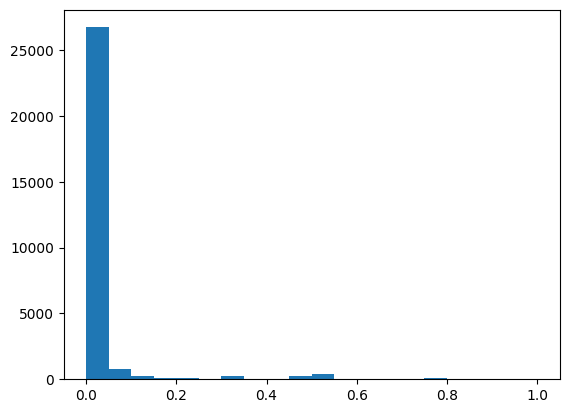

In [6]:
# Look at histogram of target jaccard similarities
plt.hist(drug_syntox_df['target_jaccard'], bins=20)

(array([12162.,  8552.,  4663.,  1302.,   395.,   445.,   117.,    17.,
           93.,   265.,    54.,    63.,    57.,   152.,     0.,   239.,
          259.,    45.,     0.,   184.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

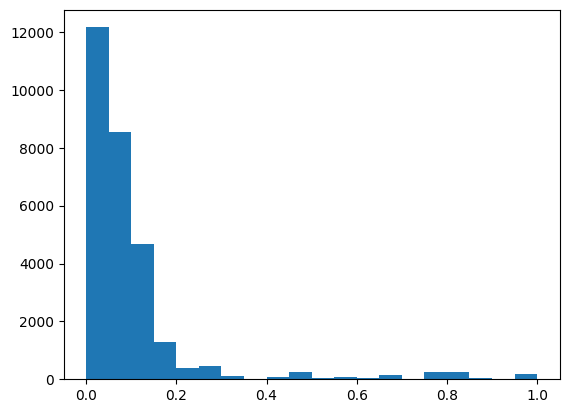

In [7]:
# Look at histogram of pathway jaccard similarities
plt.hist(drug_syntox_df['all_pw_jaccard'], bins=20)

(array([2.4707e+04, 1.5150e+03, 3.1300e+02, 6.5200e+02, 4.2600e+02,
        5.2000e+01, 4.7000e+01, 3.0000e+00, 0.0000e+00, 3.1500e+02,
        1.0900e+02, 1.0000e+00, 7.8000e+01, 1.1900e+02, 2.6000e+02,
        2.3800e+02, 4.5000e+01, 0.0000e+00, 0.0000e+00, 1.8400e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

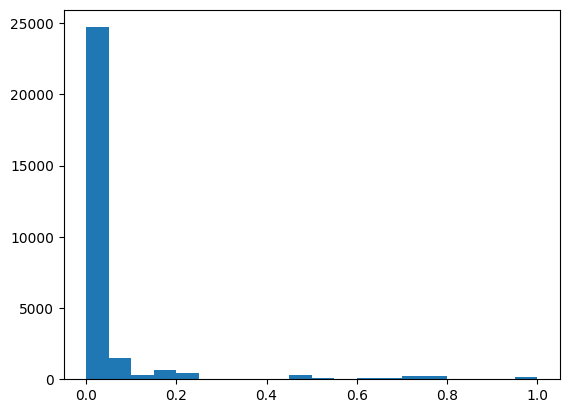

In [8]:
# Look at histogram of lowest pathway jaccard similarities
plt.hist(drug_syntox_df['lowest_pw_jaccard'], bins=20)

- Kruskal Wallis Test
- Dunn Posthoc Test with Bonferroni Correction
- Jonckheere Terpestra Test
- ANOVA
- T Test with Bonferroni Correction

In [9]:
# Run Kruskal Wallis test on jaccard similarities with targeting Major, Moderate, and Minor toxicity

# Target jaccard
major_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['target_jaccard'].dropna()
moderate_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['target_jaccard'].dropna()
minor_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['target_jaccard'].dropna()
print(f'Major target jaccard: {len(major_target)}')
print(f'Moderate target jaccard: {len(moderate_target)}')
print(f'Minor target jaccard: {len(minor_target)}')

h_statistic_target_tox, p_value_target_tox = stats.kruskal(major_target, moderate_target, minor_target)
print(f'Kruskal-Wallis H statistic for target jaccard: {h_statistic_target_tox}')
print(f'P-value for target jaccard: {p_value_target_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with target jaccard similarity of None
drug_syntox_df_tox_target = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_target = drug_syntox_df_tox_target[~drug_syntox_df_tox_target['target_jaccard'].isnull()]
dunn_target_tox = sp.posthoc_dunn(drug_syntox_df_tox_target, val_col='target_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for target jaccard:' + str(dunn_target_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_target.values.tolist()
jaccard_moderate_samples = moderate_target.values.tolist()
jaccard_minor_samples = minor_target.values.tolist()
jt_incr_target = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for Target overlap: ", jt_incr_target )
jt_decr_target = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for Target overlap: ", jt_decr_target)

# Run an ANOVA on jaccard similarity for Major, Moderate, and Minor toxicity categories
f_statistic_anova_jaccard_tox_targ, p_value_anova_jaccard_tox_targ = stats.f_oneway(major_target, moderate_target, minor_target)
print(f'ANOVA F-statistic for target jaccard: {f_statistic_anova_jaccard_tox_targ}')
print(f'P-value for target jaccard: {p_value_anova_jaccard_tox_targ}')

# Run a T test on jaccard similarity between Major/Minor, Major/Moderate, and Moderate/Minor toxicity categories
major_minor_target = stats.ttest_ind(major_target, minor_target)
major_moderate_target = stats.ttest_ind(major_target, moderate_target)
moderate_minor_target = stats.ttest_ind(moderate_target, minor_target)

# Run bonferroni correction on the p-values
ttest_p_values_targ = [major_minor_target[1], major_moderate_target[1], moderate_minor_target[1]]
ttest_p_values_corrected_targ = multipletests(ttest_p_values_targ, method='bonferroni')
print(f'Major/Minor T-test: {major_minor_target[1]} Corrected: {ttest_p_values_corrected_targ[1][0]}')
print(f'Major/Moderate T-test: {major_moderate_target[1]} Corrected: {ttest_p_values_corrected_targ[1][1]}')
print(f'Moderate/Minor T-test: {moderate_minor_target[1]} Corrected: {ttest_p_values_corrected_targ[1][2]}')

###################################
# Pathway (lowest levels) jaccard
major_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['lowest_pw_jaccard'].dropna()
moderate_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['lowest_pw_jaccard'].dropna()
minor_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['lowest_pw_jaccard'].dropna()
print(f'Major lowest pathway jaccard: {len(major_lowestpw)}')
print(f'Moderate lowest pathway jaccard: {len(moderate_lowestpw)}')
print(f'Minor lowest pathway jaccard: {len(minor_lowestpw)}')

h_statistic_lowestpw_tox, p_value_lowestpw_tox = stats.kruskal(major_lowestpw, moderate_lowestpw, minor_lowestpw)
print(f'Kruskal-Wallis H statistic for lowest pathway jaccard: {h_statistic_lowestpw_tox}')
print(f'P-value for lowest pathway jaccard: {p_value_lowestpw_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with lowest pathway levels jaccard similarity of None
drug_syntox_df_tox_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_lowestpw = drug_syntox_df_tox_lowestpw[~drug_syntox_df_tox_lowestpw['lowest_pw_jaccard'].isnull()]
dunn_lowestpw_tox = sp.posthoc_dunn(drug_syntox_df_tox_lowestpw, val_col='lowest_pw_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for lowest pathway jaccard:' + str(dunn_lowestpw_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_lowestpw.values.tolist()
jaccard_moderate_samples = moderate_lowestpw.values.tolist()
jaccard_minor_samples = minor_lowestpw.values.tolist()
jt_incr_lowestpw = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for Lowest Pathway overlap: ", jt_incr_lowestpw )
jt_decr_lowestpw = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for Lowest Pathway overlap: ", jt_decr_lowestpw)

# Run an ANOVA on jaccard similarity for Major, Moderate, and Minor toxicity categories
f_statistic_anova_jaccard_tox_lowestpw, p_value_anova_jaccard_tox_lowestpw = stats.f_oneway(major_lowestpw, moderate_lowestpw, minor_lowestpw)
print(f'ANOVA F-statistic for lowest pathway jaccard: {f_statistic_anova_jaccard_tox_lowestpw}')
print(f'P-value for lowest pathway jaccard: {p_value_anova_jaccard_tox_lowestpw}')

# Run a T test on jaccard similarity between Major/Minor, Major/Moderate, and Moderate/Minor toxicity categories
major_minor_lowestpw = stats.ttest_ind(major_lowestpw, minor_lowestpw)
major_moderate_lowestpw = stats.ttest_ind(major_lowestpw, moderate_lowestpw)
moderate_minor_lowestpw = stats.ttest_ind(moderate_lowestpw, minor_lowestpw)

# Run bonferroni correction on the p-values
ttest_p_values_lowestpw = [major_minor_lowestpw[1], major_moderate_lowestpw[1], moderate_minor_lowestpw[1]]
ttest_p_values_corrected_lowestpw = multipletests(ttest_p_values_lowestpw, method='bonferroni')
print(f'Major/Minor T-test: {major_minor_lowestpw[1]} Corrected: {ttest_p_values_corrected_lowestpw[1][0]}')
print(f'Major/Moderate T-test: {major_moderate_lowestpw[1]} Corrected: {ttest_p_values_corrected_lowestpw[1][1]}')
print(f'Moderate/Minor T-test: {moderate_minor_lowestpw[1]} Corrected: {ttest_p_values_corrected_lowestpw[1][2]}')

###################################
# Pathway (all levels) jaccard
major_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['all_pw_jaccard'].dropna()
moderate_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['all_pw_jaccard'].dropna()
minor_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['all_pw_jaccard'].dropna()
print(f'Major all pathway jaccard: {len(major_allpw)}')
print(f'Moderate all pathway jaccard: {len(moderate_allpw)}')
print(f'Minor all pathway jaccard: {len(minor_allpw)}')

h_statistic_allpw_tox, p_value_allpw_tox = stats.kruskal(major_allpw, moderate_allpw, minor_allpw)
print(f'Kruskal-Wallis H statistic for all pathway jaccard: {h_statistic_allpw_tox}')
print(f'P-value for all pathway jaccard: {p_value_allpw_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with all pathway levels jaccard similarity of None
drug_syntox_df_tox_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_allpw = drug_syntox_df_tox_allpw[~drug_syntox_df_tox_allpw['all_pw_jaccard'].isnull()]
dunn_allpw_tox = sp.posthoc_dunn(drug_syntox_df_tox_allpw, val_col='all_pw_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for all pathway jaccard:' + str(dunn_allpw_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_allpw.values.tolist()
jaccard_moderate_samples = moderate_allpw.values.tolist()
jaccard_minor_samples = minor_allpw.values.tolist()
jt_incr_allpw = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for All Pathway overlap: ", jt_incr_allpw )
jt_decr_allpw = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for All Pathway overlap: ", jt_decr_allpw)

# Run an ANOVA on jaccard similarity for Major, Moderate, and Minor toxicity categories
f_statistic_anova_jaccard_tox_allpw, p_value_anova_jaccard_tox_allpw = stats.f_oneway(major_allpw, moderate_allpw, minor_allpw)
print(f'ANOVA F-statistic for all pathway jaccard: {f_statistic_anova_jaccard_tox_allpw}')
print(f'P-value for all pathway jaccard: {p_value_anova_jaccard_tox_allpw}')

# Run a T test on jaccard similarity between Major/Minor, Major/Moderate, and Moderate/Minor toxicity categories
major_minor_allpw = stats.ttest_ind(major_allpw, minor_allpw)
major_moderate_allpw = stats.ttest_ind(major_allpw, moderate_allpw)
moderate_minor_allpw = stats.ttest_ind(moderate_allpw, minor_allpw)

# Run bonferroni correction on the p-values
ttest_p_values_allpw = [major_minor_allpw[1], major_moderate_allpw[1], moderate_minor_allpw[1]]
ttest_p_values_corrected_allpw = multipletests(ttest_p_values_allpw, method='bonferroni')
print(f'Major/Minor T-test: {major_minor_allpw[1]} Corrected: {ttest_p_values_corrected_allpw[1][0]}')
print(f'Major/Moderate T-test: {major_moderate_allpw[1]} Corrected: {ttest_p_values_corrected_allpw[1][1]}')
print(f'Moderate/Minor T-test: {moderate_minor_allpw[1]} Corrected: {ttest_p_values_corrected_allpw[1][2]}')


with open('results/jaccard_similarity_analysis/targpw_tox_jaccard_ddinter.tsv', 'w') as f:
    f.write('Level\tTest\tTest statistic\tP-value\n')
    f.write(f'Target\tKruskal-Wallis\t{h_statistic_target_tox}\t{p_value_target_tox}\n')
    f.write(f'Target\tDunn post-hoc\tMajor/Minor\t{dunn_target_tox.iloc[0, 1]}\n')
    f.write(f'Target\tDunn post-hoc\tMajor/Moderate\t{dunn_target_tox.iloc[0, 2]}\n')
    f.write(f'Target\tDunn post-hoc\tModerate/Minor\t{dunn_target_tox.iloc[1, 2]}\n')
    f.write(f'Target\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_target[0]}\t{jt_incr_target[1]}\n')
    f.write(f'Target\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_target[0]}\t{jt_decr_target[1]}\n')
    f.write(f'Target\tANOVA\t{f_statistic_anova_jaccard_tox_targ}\t{p_value_anova_jaccard_tox_targ}\n')
    f.write(f'Target\tT-test (bonf cor)\tMajor/Minor\t{ttest_p_values_corrected_targ[1][0]}\n')
    f.write(f'Target\tT-test (bonf cor)\tMajor/Moderate\t{ttest_p_values_corrected_targ[1][1]}\n')
    f.write(f'Target\tT-test (bonf cor)\tModerate/Minor\t{ttest_p_values_corrected_targ[1][2]}\n')
    f.write(f'Lowest pathway\tKruskal-Wallis\t{h_statistic_lowestpw_tox}\t{p_value_lowestpw_tox}\n')
    f.write(f'Lowest pathway\tDunn post-hoc\tMajor/Minor\t{dunn_lowestpw_tox.iloc[0, 1]}\n')
    f.write(f'Lowest pathway\tDunn post-hoc\tMajor/Moderate\t{dunn_lowestpw_tox.iloc[0, 2]}\n')
    f.write(f'Lowest pathway\tDunn post-hoc\tModerate/Minor\t{dunn_lowestpw_tox.iloc[1, 2]}\n')
    f.write(f'Lowest pathway\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_lowestpw[0]}\t{jt_incr_lowestpw[1]}\n')
    f.write(f'Lowest pathway\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_lowestpw[0]}\t{jt_decr_lowestpw[1]}\n')
    f.write(f'Lowest pathway\tANOVA\t{f_statistic_anova_jaccard_tox_lowestpw}\t{p_value_anova_jaccard_tox_lowestpw}\n')
    f.write(f'Lowest pathway\tT-test (bonf cor)\tMajor/Minor\t{ttest_p_values_corrected_lowestpw[1][0]}\n')
    f.write(f'Lowest pathway\tT-test (bonf cor)\tMajor/Moderate\t{ttest_p_values_corrected_lowestpw[1][1]}\n')
    f.write(f'Lowest pathway\tT-test (bonf cor)\tModerate/Minor\t{ttest_p_values_corrected_lowestpw[1][2]}\n')
    f.write(f'All pathway\tKruskal-Wallis\t{h_statistic_allpw_tox}\t{p_value_allpw_tox}\n')
    f.write(f'All pathway\tDunn post-hoc\tMajor/Minor\t{dunn_allpw_tox.iloc[0, 1]}\n')
    f.write(f'All pathway\tDunn post-hoc\tMajor/Moderate\t{dunn_allpw_tox.iloc[0, 2]}\n')
    f.write(f'All pathway\tDunn post-hoc\tModerate/Minor\t{dunn_allpw_tox.iloc[1, 2]}\n')
    f.write(f'All pathway\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_allpw[0]}\t{jt_incr_allpw[1]}\n')
    f.write(f'All pathway\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_allpw[0]}\t{jt_decr_allpw[1]}\n')
    f.write(f'All pathway\tANOVA\t{f_statistic_anova_jaccard_tox_allpw}\t{p_value_anova_jaccard_tox_allpw}\n')
    f.write(f'All pathway\tT-test (bonf cor)\tMajor/Minor\t{ttest_p_values_corrected_allpw[1][0]}\n')
    f.write(f'All pathway\tT-test (bonf cor)\tMajor/Moderate\t{ttest_p_values_corrected_allpw[1][1]}\n')
    f.write(f'All pathway\tT-test (bonf cor)\tModerate/Minor\t{ttest_p_values_corrected_allpw[1][2]}\n')



Major target jaccard: 5776
Moderate target jaccard: 22457
Minor target jaccard: 831
Kruskal-Wallis H statistic for target jaccard: 156.47337491620945
P-value for target jaccard: 1.05253938225393e-34
Dunn post-hoc test for target jaccard:                 Major         Minor      Moderate
Major     1.000000e+00  1.352075e-25  9.079921e-22
Minor     1.352075e-25  1.000000e+00  5.719235e-12
Moderate  9.079921e-22  5.719235e-12  1.000000e+00
Increasing toxicity for Target overlap:  (5.678687992488283, 6.7865901787200755e-09)
Decreasing toxicity for Target overlap:  (-5.678687992488283, 0.9999999932134098)
ANOVA F-statistic for target jaccard: 59.04294758218222
P-value for target jaccard: 2.569979299379355e-26
Major/Minor T-test: 1.0240378198165778e-10 Corrected: 3.072113459449733e-10
Major/Moderate T-test: 3.252126465384883e-19 Corrected: 9.756379396154649e-19
Moderate/Minor T-test: 8.365529073661651e-10 Corrected: 2.5096587220984955e-09
Major lowest pathway jaccard: 5776
Moderate lowest pa

- Violin Plots

In [10]:
colors = ['#20965D', '#FFBC42', '#D81159']
tox_order = ['Minor', 'Moderate', 'Major']
color_dict = dict(zip(tox_order, colors))
legend_elements = [
    Patch(facecolor=color_dict[cat], label = cat) for cat in tox_order
]

ax = sns.violinplot(data=drug_syntox_df, x='toxicity_category', y='target_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Protein Drug Target Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/drugtargjs_v_toxcats_ddinter_violin.png', dpi=700)
plt.close()

ax = sns.violinplot(data=drug_syntox_df, x='toxicity_category', y='lowest_pw_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Lowest Reactome Pathways Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/lowestpwjs_v_toxcats_ddinter_violin.png', dpi=700)
plt.close()

ax = sns.violinplot(data=drug_syntox_df, x='toxicity_category', y='all_pw_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('All Reactome Pathways Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/allpwjs_v_toxcats_ddinter_violin.png', dpi=700)
plt.close()


- Strip Plots

In [11]:
# Create scatter plots instead of violin plots

ax = sns.stripplot(data=drug_syntox_df, x='toxicity_category', y='target_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Protein Drug Target Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/drugtargjs_v_toxcats_ddinter_strip.png', dpi=700)
plt.close()

ax = sns.stripplot(data=drug_syntox_df, x='toxicity_category', y='lowest_pw_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Lowest Reactome Pathways Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/lowestpwjs_v_toxcats_ddinter_strip.png', dpi=700)
plt.close()

ax = sns.stripplot(data=drug_syntox_df, x='toxicity_category', y='all_pw_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('All Reactome Pathways Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/allpwjs_v_toxcats_ddinter_strip.png', dpi=700)
plt.close()

- Correlation Scatter Plots (target jaccard similarity v Synergy Scores)
- R^2 value
- Best fit line
- Pearson correlation coefficient
- Spearman correlation coefficient

In [12]:
################### TARGET ###################
##############################################

x_targjs = drug_syntox_df['target_jaccard'].dropna()
y_targjs_bliss_true = drug_syntox_df[drug_syntox_df['target_jaccard'].notna()]['synergy_bliss']
y_targjs_loewe_true = drug_syntox_df[drug_syntox_df['target_jaccard'].notna()]['synergy_loewe']
y_targjs_hsa_true = drug_syntox_df[drug_syntox_df['target_jaccard'].notna()]['synergy_hsa']
y_targjs_zip_true = drug_syntox_df[drug_syntox_df['target_jaccard'].notna()]['synergy_zip']

####### BLISS ########
# Let's plot target jaccard similarity against bliss synergy scores
plt.scatter(x_targjs, y_targjs_bliss_true)

# Best fit line
z_targjs_bliss = np.polyfit(x_targjs, y_targjs_bliss_true, 1)
p_targjs_bliss = np.poly1d(z_targjs_bliss)
y_targjs_bliss_pred = p_targjs_bliss(x_targjs)
r_squared_targjs_bliss = r2_score(y_targjs_bliss_true, y_targjs_bliss_pred)
plt.plot(x_targjs, y_targjs_bliss_pred, "r-", alpha=0.8, label=f'y = {z_targjs_bliss[0]:.3f}x + {z_targjs_bliss[1]:.3f}\nR² = {r_squared_targjs_bliss:.3f}')

plt.xlabel('Protein Drug Target Jaccard Similarity')
plt.ylabel('Bliss Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/bliss_v_targjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between target jaccard similarity and bliss synergy score
targjs_bliss_corr = x_targjs.corr(y_targjs_bliss_true)
print(f'Pearson correlation coefficient between target jaccard similarity and bliss synergy score: {targjs_bliss_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and bliss synergy score
targjs_bliss_spearman_corr = x_targjs.corr(y_targjs_bliss_true, method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and bliss synergy score: {targjs_bliss_spearman_corr}')

####### HSA ########
# Let's plot target jaccard similarity against hsa synergy scores
plt.scatter(x_targjs, y_targjs_hsa_true)

# Best fit line
z_targjs_hsa = np.polyfit(x_targjs, y_targjs_hsa_true, 1)
p_targjs_hsa = np.poly1d(z_targjs_hsa)
y_targjs_hsa_pred = p_targjs_hsa(x_targjs)
r_squared_targjs_hsa = r2_score(y_targjs_hsa_true, y_targjs_hsa_pred)
plt.plot(x_targjs, y_targjs_hsa_pred, "r-", alpha=0.8, label=f'y = {z_targjs_hsa[0]:.3f}x + {z_targjs_hsa[1]:.3f}\nR² = {r_squared_targjs_hsa:.3f}')

plt.xlabel('Protein Drug Target Jaccard Similarity')
plt.ylabel('HSA Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/hsa_v_targjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between target jaccard similarity and hsa synergy score
targjs_hsa_corr = x_targjs.corr(y_targjs_hsa_true)
print(f'Pearson correlation coefficient between target jaccard similarity and hsa synergy score: {targjs_hsa_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and hsa synergy score
targjs_hsa_spearman_corr = x_targjs.corr(y_targjs_hsa_true, method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and hsa synergy score: {targjs_hsa_spearman_corr}')

####### LOEWE ########
# Let's plot target jaccard similarity against loewe synergy scores
plt.scatter(x_targjs, y_targjs_loewe_true)

# Best fit line
z_targjs_loewe = np.polyfit(x_targjs, y_targjs_loewe_true, 1)
p_targjs_loewe = np.poly1d(z_targjs_loewe)
y_targjs_loewe_pred = p_targjs_loewe(x_targjs)
r_squared_targjs_loewe = r2_score(y_targjs_loewe_true, y_targjs_loewe_pred)
plt.plot(x_targjs, y_targjs_loewe_pred, "r-", alpha=0.8, label=f'y = {z_targjs_loewe[0]:.3f}x + {z_targjs_loewe[1]:.3f}\nR² = {r_squared_targjs_loewe:.3f}')

plt.xlabel('Protein Drug Target Jaccard Similarity')
plt.ylabel('Loewe Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/loewe_v_targjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between target jaccard similarity and loewe synergy score
targjs_loewe_corr = x_targjs.corr(y_targjs_loewe_true)
print(f'Pearson correlation coefficient between target jaccard similarity and loewe synergy score: {targjs_loewe_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and loewe synergy score
targjs_loewe_spearman_corr = x_targjs.corr(y_targjs_loewe_true, method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and loewe synergy score: {targjs_loewe_spearman_corr}')

####### ZIP ########
# Let's plot target jaccard similarity against zip synergy scores
plt.scatter(x_targjs, y_targjs_zip_true)

# Best fit line
z_targjs_zip = np.polyfit(x_targjs, y_targjs_zip_true, 1)
p_targjs_zip = np.poly1d(z_targjs_zip)
y_targjs_zip_pred = p_targjs_zip(x_targjs)
r_squared_targjs_zip = r2_score(y_targjs_zip_true, y_targjs_zip_pred)
plt.plot(x_targjs, y_targjs_zip_pred, "r-", alpha=0.8, label=f'y = {z_targjs_zip[0]:.3f}x + {z_targjs_zip[1]:.3f}\nR² = {r_squared_targjs_zip:.3f}')

plt.xlabel('Protein Drug Target Jaccard Similarity')
plt.ylabel('ZIP Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/zip_v_targjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between target jaccard similarity and zip synergy score
targjs_zip_corr = x_targjs.corr(y_targjs_zip_true)
print(f'Pearson correlation coefficient between target jaccard similarity and zip synergy score: {targjs_zip_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and zip synergy score
targjs_zip_spearman_corr = x_targjs.corr(y_targjs_zip_true, method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and zip synergy score: {targjs_zip_spearman_corr}')


Pearson correlation coefficient between target jaccard similarity and bliss synergy score: -0.01762477911418044
Spearman correlation coefficient between target jaccard similarity and bliss synergy score: -0.004092025662425794
Pearson correlation coefficient between target jaccard similarity and hsa synergy score: -0.007835543609508614
Spearman correlation coefficient between target jaccard similarity and hsa synergy score: -0.026949046716731657
Pearson correlation coefficient between target jaccard similarity and loewe synergy score: 0.06347057723748037
Spearman correlation coefficient between target jaccard similarity and loewe synergy score: 0.07198351275880906
Pearson correlation coefficient between target jaccard similarity and zip synergy score: -0.01960691992870583
Spearman correlation coefficient between target jaccard similarity and zip synergy score: -0.006493363240289049


In [13]:
################### ALL PATHWAY ###################
###################################################

x_allpwjs = drug_syntox_df['all_pw_jaccard'].dropna()
y_allpwjs_bliss_true = drug_syntox_df[drug_syntox_df['all_pw_jaccard'].notna()]['synergy_bliss']
y_allpwjs_loewe_true = drug_syntox_df[drug_syntox_df['all_pw_jaccard'].notna()]['synergy_loewe']
y_allpwjs_hsa_true = drug_syntox_df[drug_syntox_df['all_pw_jaccard'].notna()]['synergy_hsa']
y_allpwjs_zip_true = drug_syntox_df[drug_syntox_df['all_pw_jaccard'].notna()]['synergy_zip']

####### BLISS ########
# Let's plot all pathway jaccard similarity against bliss synergy scores
plt.scatter(x_allpwjs, y_allpwjs_bliss_true)

# Best fit line
z_allpwjs_bliss = np.polyfit(x_allpwjs, y_allpwjs_bliss_true, 1)
p_allpwjs_bliss = np.poly1d(z_allpwjs_bliss)
y_allpwjs_bliss_pred = p_allpwjs_bliss(x_allpwjs)
r_squared_allpwjs_bliss = r2_score(y_allpwjs_bliss_true, y_allpwjs_bliss_pred)
plt.plot(x_allpwjs, y_allpwjs_bliss_pred, "r-", alpha=0.8, label=f'y = {z_allpwjs_bliss[0]:.3f}x + {z_allpwjs_bliss[1]:.3f}\nR² = {r_squared_allpwjs_bliss:.3f}')

plt.xlabel('All Reactome Pathways Jaccard Similarity')
plt.ylabel('Bliss Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/bliss_v_allpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between all pathway jaccard similarity and bliss synergy score
allpwjs_bliss_corr = x_allpwjs.corr(y_allpwjs_bliss_true)
print(f'Pearson correlation coefficient between all pathway jaccard similarity and bliss synergy score: {allpwjs_bliss_corr}')

# Calculate Spearman correlation coefficient between all pathway jaccard similarity and bliss synergy score
allpwjs_bliss_spearman_corr = x_allpwjs.corr(y_allpwjs_bliss_true, method='spearman')
print(f'Spearman correlation coefficient between all pathway jaccard similarity and bliss synergy score: {allpwjs_bliss_spearman_corr}')

####### HSA ########
# Let's plot all pathway jaccard similarity against hsa synergy scores
plt.scatter(x_allpwjs, y_allpwjs_hsa_true)

# Best fit line
z_allpwjs_hsa = np.polyfit(x_allpwjs, y_allpwjs_hsa_true, 1)
p_allpwjs_hsa = np.poly1d(z_allpwjs_hsa)
y_allpwjs_hsa_pred = p_allpwjs_hsa(x_allpwjs)
r_squared_allpwjs_hsa = r2_score(y_allpwjs_hsa_true, y_allpwjs_hsa_pred)
plt.plot(x_allpwjs, y_allpwjs_hsa_pred, "r-", alpha=0.8, label=f'y = {z_allpwjs_hsa[0]:.3f}x + {z_allpwjs_hsa[1]:.3f}\nR² = {r_squared_allpwjs_hsa:.3f}')

plt.xlabel('All Reactome Pathways Jaccard Similarity')
plt.ylabel('HSA Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/hsa_v_allpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between all pathway jaccard similarity and hsa synergy score
allpwjs_hsa_corr = x_allpwjs.corr(y_allpwjs_hsa_true)
print(f'Pearson correlation coefficient between all pathway jaccard similarity and hsa synergy score: {allpwjs_hsa_corr}')

# Calculate Spearman correlation coefficient between all pathway jaccard similarity and hsa synergy score
allpwjs_hsa_spearman_corr = x_allpwjs.corr(y_allpwjs_hsa_true, method='spearman')
print(f'Spearman correlation coefficient between all pathway jaccard similarity and hsa synergy score: {allpwjs_hsa_spearman_corr}')

####### LOEWE ########
# Let's plot all pathway jaccard similarity against loewe synergy scores
plt.scatter(x_allpwjs, y_allpwjs_loewe_true)

# Best fit line
z_allpwjs_loewe = np.polyfit(x_allpwjs, y_allpwjs_loewe_true, 1)
p_allpwjs_loewe = np.poly1d(z_allpwjs_loewe)
y_allpwjs_loewe_pred = p_allpwjs_loewe(x_allpwjs)
r_squared_allpwjs_loewe = r2_score(y_allpwjs_loewe_true, y_allpwjs_loewe_pred)
plt.plot(x_allpwjs, y_allpwjs_loewe_pred, "r-", alpha=0.8, label=f'y = {z_allpwjs_loewe[0]:.3f}x + {z_allpwjs_loewe[1]:.3f}\nR² = {r_squared_allpwjs_loewe:.3f}')

plt.xlabel('All Reactome Pathways Jaccard Similarity')
plt.ylabel('Loewe Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/loewe_v_allpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between all pathway jaccard similarity and loewe synergy score
allpwjs_loewe_corr = x_allpwjs.corr(y_allpwjs_loewe_true)
print(f'Pearson correlation coefficient between all pathway jaccard similarity and loewe synergy score: {allpwjs_loewe_corr}')

# Calculate Spearman correlation coefficient between all pathway jaccard similarity and loewe synergy score
allpwjs_loewe_spearman_corr = x_allpwjs.corr(y_allpwjs_loewe_true, method='spearman')
print(f'Spearman correlation coefficient between all pathway jaccard similarity and loewe synergy score: {allpwjs_loewe_spearman_corr}')

####### ZIP ########
# Let's plot all pathway jaccard similarity against zip synergy scores
plt.scatter(x_allpwjs, y_allpwjs_zip_true)

# Best fit line
z_allpwjs_zip = np.polyfit(x_allpwjs, y_allpwjs_zip_true, 1)
p_allpwjs_zip = np.poly1d(z_allpwjs_zip)
y_allpwjs_zip_pred = p_allpwjs_zip(x_allpwjs)
r_squared_allpwjs_zip = r2_score(y_allpwjs_zip_true, y_allpwjs_zip_pred)
plt.plot(x_allpwjs, y_allpwjs_zip_pred, "r-", alpha=0.8, label=f'y = {z_allpwjs_zip[0]:.3f}x + {z_allpwjs_zip[1]:.3f}\nR² = {r_squared_allpwjs_zip:.3f}')

plt.xlabel('All Reactome Pathways Jaccard Similarity')
plt.ylabel('ZIP Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/zip_v_allpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between all pathway jaccard similarity and zip synergy score
allpwjs_zip_corr = x_allpwjs.corr(y_allpwjs_zip_true)
print(f'Pearson correlation coefficient between all pathway jaccard similarity and zip synergy score: {allpwjs_zip_corr}')

# Calculate Spearman correlation coefficient between all pathway jaccard similarity and zip synergy score
allpwjs_zip_spearman_corr = x_allpwjs.corr(y_allpwjs_zip_true, method='spearman')
print(f'Spearman correlation coefficient between all pathway jaccard similarity and zip synergy score: {allpwjs_zip_spearman_corr}')


Pearson correlation coefficient between all pathway jaccard similarity and bliss synergy score: -0.001457456854270684
Spearman correlation coefficient between all pathway jaccard similarity and bliss synergy score: 0.03474391506554247
Pearson correlation coefficient between all pathway jaccard similarity and hsa synergy score: -0.005695518008089778
Spearman correlation coefficient between all pathway jaccard similarity and hsa synergy score: -0.02796440586969088
Pearson correlation coefficient between all pathway jaccard similarity and loewe synergy score: 0.06859291068298352
Spearman correlation coefficient between all pathway jaccard similarity and loewe synergy score: 0.029482611419584498
Pearson correlation coefficient between all pathway jaccard similarity and zip synergy score: -0.0002975476998301229
Spearman correlation coefficient between all pathway jaccard similarity and zip synergy score: 0.03744505974988322


In [14]:
################### LOWEST PATHWAY ###################
######################################################
x_lowestpwjs = drug_syntox_df['lowest_pw_jaccard'].dropna()
y_lowestpwjs_bliss_true = drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].notna()]['synergy_bliss']
y_lowestpwjs_loewe_true = drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].notna()]['synergy_loewe']
y_lowestpwjs_hsa_true = drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].notna()]['synergy_hsa']
y_lowestpwjs_zip_true = drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].notna()]['synergy_zip']

####### BLISS ########
# Let's plot lowest pathway jaccard similarity against bliss synergy scores
plt.scatter(x_lowestpwjs, y_lowestpwjs_bliss_true)

# Best fit line
z_lowestpwjs_bliss = np.polyfit(x_lowestpwjs, y_lowestpwjs_bliss_true, 1)
p_lowestpwjs_bliss = np.poly1d(z_lowestpwjs_bliss)
y_lowestpwjs_bliss_pred = p_lowestpwjs_bliss(x_lowestpwjs)
r_squared_lowestpwjs_bliss = r2_score(y_lowestpwjs_bliss_true, y_lowestpwjs_bliss_pred)
plt.plot(x_lowestpwjs, y_lowestpwjs_bliss_pred, "r-", alpha=0.8, label=f'y = {z_lowestpwjs_bliss[0]:.3f}x + {z_lowestpwjs_bliss[1]:.3f}\nR² = {r_squared_lowestpwjs_bliss:.3f}')

plt.xlabel('Lowest Reactome Pathways Jaccard Similarity')
plt.ylabel('Bliss Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/bliss_v_lowestpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between lowest pathway jaccard similarity and bliss synergy score
lowestpwjs_bliss_corr = x_lowestpwjs.corr(y_lowestpwjs_bliss_true)
print(f'Pearson correlation coefficient between lowest pathway jaccard similarity and bliss synergy score: {lowestpwjs_bliss_corr}')

# Calculate Spearman correlation coefficient between lowest pathway jaccard similarity and bliss synergy score
lowestpwjs_bliss_spearman_corr = x_lowestpwjs.corr(y_lowestpwjs_bliss_true, method='spearman')
print(f'Spearman correlation coefficient between lowest pathway jaccard similarity and bliss synergy score: {lowestpwjs_bliss_spearman_corr}')

####### HSA ########
# Let's plot lowest pathway jaccard similarity against hsa synergy scores
plt.scatter(x_lowestpwjs, y_lowestpwjs_hsa_true)

# Best fit line
z_lowestpwjs_hsa = np.polyfit(x_lowestpwjs, y_lowestpwjs_hsa_true, 1)
p_lowestpwjs_hsa = np.poly1d(z_lowestpwjs_hsa)
y_lowestpwjs_hsa_pred = p_lowestpwjs_hsa(x_lowestpwjs)
r_squared_lowestpwjs_hsa = r2_score(y_lowestpwjs_hsa_true, y_lowestpwjs_hsa_pred)
plt.plot(x_lowestpwjs, y_lowestpwjs_hsa_pred, "r-", alpha=0.8, label=f'y = {z_lowestpwjs_hsa[0]:.3f}x + {z_lowestpwjs_hsa[1]:.3f}\nR² = {r_squared_lowestpwjs_hsa:.3f}')

plt.xlabel('Lowest Reactome Pathways Jaccard Similarity')
plt.ylabel('HSA Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/hsa_v_lowestpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between lowest pathway jaccard similarity and hsa synergy score
lowestpwjs_hsa_corr = x_lowestpwjs.corr(y_lowestpwjs_hsa_true)
print(f'Pearson correlation coefficient between lowest pathway jaccard similarity and hsa synergy score: {lowestpwjs_hsa_corr}')

# Calculate Spearman correlation coefficient between lowest pathway jaccard similarity and hsa synergy score
lowestpwjs_hsa_spearman_corr = x_lowestpwjs.corr(y_lowestpwjs_hsa_true, method='spearman')
print(f'Spearman correlation coefficient between lowest pathway jaccard similarity and hsa synergy score: {lowestpwjs_hsa_spearman_corr}')

####### LOEWE ########
# Let's plot lowest pathway jaccard similarity against loewe synergy scores
plt.scatter(x_lowestpwjs, y_lowestpwjs_loewe_true)

# Best fit line
z_lowestpwjs_loewe = np.polyfit(x_lowestpwjs, y_lowestpwjs_loewe_true, 1)
p_lowestpwjs_loewe = np.poly1d(z_lowestpwjs_loewe)
y_lowestpwjs_loewe_pred = p_lowestpwjs_loewe(x_lowestpwjs)
r_squared_lowestpwjs_loewe = r2_score(y_lowestpwjs_loewe_true, y_lowestpwjs_loewe_pred)
plt.plot(x_lowestpwjs, y_lowestpwjs_loewe_pred, "r-", alpha=0.8, label=f'y = {z_lowestpwjs_loewe[0]:.3f}x + {z_lowestpwjs_loewe[1]:.3f}\nR² = {r_squared_lowestpwjs_loewe:.3f}')

plt.xlabel('Lowest Reactome Pathways Jaccard Similarity')
plt.ylabel('Loewe Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/loewe_v_lowestpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between lowest pathway jaccard similarity and loewe synergy score
lowestpwjs_loewe_corr = x_lowestpwjs.corr(y_lowestpwjs_loewe_true)
print(f'Pearson correlation coefficient between lowest pathway jaccard similarity and loewe synergy score: {lowestpwjs_loewe_corr}')

# Calculate Spearman correlation coefficient between lowest pathway jaccard similarity and loewe synergy score
lowestpwjs_loewe_spearman_corr = x_lowestpwjs.corr(y_lowestpwjs_loewe_true, method='spearman')
print(f'Spearman correlation coefficient between lowest pathway jaccard similarity and loewe synergy score: {lowestpwjs_loewe_spearman_corr}')

####### ZIP ########
# Let's plot lowest pathway jaccard similarity against zip synergy scores
plt.scatter(x_lowestpwjs, y_lowestpwjs_zip_true)

# Best fit line
z_lowestpwjs_zip = np.polyfit(x_lowestpwjs, y_lowestpwjs_zip_true, 1)
p_lowestpwjs_zip = np.poly1d(z_lowestpwjs_zip)
y_lowestpwjs_zip_pred = p_lowestpwjs_zip(x_lowestpwjs)
r_squared_lowestpwjs_zip = r2_score(y_lowestpwjs_zip_true, y_lowestpwjs_zip_pred)
plt.plot(x_lowestpwjs, y_lowestpwjs_zip_pred, "r-", alpha=0.8, label=f'y = {z_lowestpwjs_zip[0]:.3f}x + {z_lowestpwjs_zip[1]:.3f}\nR² = {r_squared_lowestpwjs_zip:.3f}')

plt.xlabel('Lowest Reactome Pathways Jaccard Similarity')
plt.ylabel('ZIP Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/jaccard_similarity_analysis/zip_v_lowestpwjs_ddinter_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between lowest pathway jaccard similarity and zip synergy score
lowestpwjs_zip_corr = x_lowestpwjs.corr(y_lowestpwjs_zip_true)
print(f'Pearson correlation coefficient between lowest pathway jaccard similarity and zip synergy score: {lowestpwjs_zip_corr}')

# Calculate Spearman correlation coefficient between lowest pathway jaccard similarity and zip synergy score
lowestpwjs_zip_spearman_corr = x_lowestpwjs.corr(y_lowestpwjs_zip_true, method='spearman')
print(f'Spearman correlation coefficient between lowest pathway jaccard similarity and zip synergy score: {lowestpwjs_zip_spearman_corr}')

Pearson correlation coefficient between lowest pathway jaccard similarity and bliss synergy score: -0.0063912914991291064
Spearman correlation coefficient between lowest pathway jaccard similarity and bliss synergy score: 0.028559997041366556
Pearson correlation coefficient between lowest pathway jaccard similarity and hsa synergy score: -0.0031003729267797507
Spearman correlation coefficient between lowest pathway jaccard similarity and hsa synergy score: -0.042874603757707755
Pearson correlation coefficient between lowest pathway jaccard similarity and loewe synergy score: 0.07598914822838
Spearman correlation coefficient between lowest pathway jaccard similarity and loewe synergy score: 0.057597524050639094
Pearson correlation coefficient between lowest pathway jaccard similarity and zip synergy score: -0.006038601174204547
Spearman correlation coefficient between lowest pathway jaccard similarity and zip synergy score: 0.026652386512340143


In [15]:
# Write all the correlations and spearman correlations to a file
with open('results/jaccard_similarity_analysis/targpw_v_synergy_correlations_ddinter.tsv', 'w') as f:
    f.write('Synergy score\tLevel\tPearson correlation coefficient\tSpearman correlation\tR squared value\n')
    f.write(f'Bliss\ttarget jaccard similarity\t{targjs_bliss_corr}\t{targjs_bliss_spearman_corr}\t{r_squared_targjs_bliss}\n')
    f.write(f'HSA\ttarget jaccard similarity\t{targjs_hsa_corr}\t{targjs_hsa_spearman_corr}\t{r_squared_targjs_hsa}\n')
    f.write(f'Loewe\ttarget jaccard similarity\t{targjs_loewe_corr}\t{targjs_loewe_spearman_corr}\t{r_squared_targjs_loewe}\n')
    f.write(f'ZIP\ttarget jaccard similarity\t{targjs_zip_corr}\t{targjs_zip_spearman_corr}\t{r_squared_targjs_zip}\n')
    f.write(f'Bliss\tall pathway jaccard similarity\t{allpwjs_bliss_corr}\t{allpwjs_bliss_spearman_corr}\t{r_squared_allpwjs_bliss}\n')
    f.write(f'HSA\tall pathway jaccard similarity\t{allpwjs_hsa_corr}\t{allpwjs_hsa_spearman_corr}\t{r_squared_allpwjs_hsa}\n')
    f.write(f'Loewe\tall pathway jaccard similarity\t{allpwjs_loewe_corr}\t{allpwjs_loewe_spearman_corr}\t{r_squared_allpwjs_loewe}\n')
    f.write(f'ZIP\tall pathway jaccard similarity\t{allpwjs_zip_corr}\t{allpwjs_zip_spearman_corr}\t{r_squared_allpwjs_zip}\n')
    f.write(f'Bliss\tlowest pathway jaccard similarity\t{lowestpwjs_bliss_corr}\t{lowestpwjs_bliss_spearman_corr}\t{r_squared_lowestpwjs_bliss}\n')
    f.write(f'HSA\tlowest pathway jaccard similarity\t{lowestpwjs_hsa_corr}\t{lowestpwjs_hsa_spearman_corr}\t{r_squared_lowestpwjs_hsa}\n')
    f.write(f'Loewe\tlowest pathway jaccard similarity\t{lowestpwjs_loewe_corr}\t{lowestpwjs_loewe_spearman_corr}\t{r_squared_lowestpwjs_loewe}\n')
    f.write(f'ZIP\tlowest pathway jaccard similarity\t{lowestpwjs_zip_corr}\t{lowestpwjs_zip_spearman_corr}\t{r_squared_lowestpwjs_zip}\n')
